In [44]:
import numpy as np
from torch.nn import CrossEntropyLoss
import torch
import matplotlib.pyplot as plt
import scipy
import tqdm
from sklearn import metrics
plt.style.use("ggplot")

In [45]:
# Load logits and train indices
N_MODELS = 100
N_CLASSES = 10
teacher_logits_zip = np.load(f"./saves/logits/logits_resnet_0.npz")
teacher_logits = np.concatenate([teacher_logits_zip['logits_arr_train'], teacher_logits_zip['logits_arr_test']])
targets = np.concatenate([teacher_logits_zip['targets_arr_train'], teacher_logits_zip['targets_arr_test']])
teacher_train_indices = np.load("./indices/train_idx_0.npy")


student_logits = np.empty((N_MODELS, 60000, 10), dtype=np.float32)
student_train_indices = np.empty((N_MODELS, 30000))
for idx in range(1, N_MODELS+1):
    x = np.load(f"./saves-MLP/logits/logits_mlp_{idx}.npz")
    x = np.concatenate([x['logits_arr_train'], x['logits_arr_test']])
    student_logits[idx-1,:,:] = x
    student_train_indices[idx-1,:] = np.load(f"./indices/train_idx_{idx}.npy")

In [46]:
# Convert all logits to confidence scores
loss = CrossEntropyLoss(reduction='none')
teacher_cfs = np.empty((60000, 10))
for class_nr in range(N_CLASSES):
    teacher_cfs[:, class_nr] = loss(torch.Tensor(teacher_logits), torch.Tensor(60000*[class_nr]).type(torch.LongTensor)).numpy()
teacher_cfs = np.exp(-1 * teacher_cfs)


student_cfs = np.empty((N_MODELS, 60000, 10))
for k in range(1, N_MODELS+1):
    for class_nr in range(N_CLASSES):  
        student_cfs[k-1, :, class_nr] = loss(torch.Tensor(student_logits[k-1,:]), torch.Tensor(60000*[class_nr]).type(torch.LongTensor)).numpy()
student_cfs = np.exp(-1 * student_cfs)

In [47]:
# Numerically stable way to apply logit scaling to confidence scores

mask = np.ones((60000, N_CLASSES), dtype=bool)
mask[range(60000), list(targets.astype(np.int64))] = False
teacher_cfs_wrong = teacher_cfs[mask].reshape(60000, N_CLASSES-1)
teacher_logits = np.log(np.choose(list(targets.astype(np.int64)), teacher_cfs.T)+1e-45) - np.log(teacher_cfs_wrong.sum(1)+1e-45)

student_logits = np.empty((N_MODELS, 60000))
for k in range(1, N_MODELS+1):
    mask = np.ones((60000, N_CLASSES), dtype=bool)
    mask[range(60000), list(targets.astype(np.int64))] = False
    student_cfs_wrong = student_cfs[k-1, :, :][mask].reshape(60000, N_CLASSES-1)
    student_logits[k-1, :] = np.log(np.choose(list(targets.astype(np.int64)), student_cfs[k-1, :, :].T)+1e-45) - np.log(student_cfs_wrong.sum(1)+1e-45)

In [48]:
student_logits.shape

(100, 60000)

In [49]:
member_indicators = []
member_scores = []
skipped = 0

for train_idx in tqdm.tqdm(range(0, 60000)):
    idx_in_train_dataset = np.any(student_train_indices == train_idx, axis=1)

    # get IN models logits
    in_logits = student_logits[idx_in_train_dataset][:, train_idx]

    # get OUT models logits
    out_logits = student_logits[~idx_in_train_dataset][:, train_idx]

    # get teacher model logit
    teacher_logit = teacher_logits[train_idx]

    if len(in_logits)/N_MODELS > 0.65 or len(out_logits)/N_MODELS > 0.65:
        #print(f"Unbalanced data for idx {train_idx}. Skipping ...")
        skipped += 1


    # Calibrate normal dist for IN
    s_in = np.std(in_logits)
    m_in = np.mean(in_logits)

    # Calibrate normal dist for OUT
    s_out = np.std(out_logits)
    m_out = np.mean(out_logits)

    # Set is_member indicator for sample
    if train_idx in teacher_train_indices:
        member_indicators.append(1)
    else:
        member_indicators.append(0)

    # Calculate is_member score for sample
    score = scipy.stats.norm.pdf(teacher_logit, m_in, s_in) / (scipy.stats.norm.pdf(teacher_logit, m_out, s_out) + 1e-40)
    member_scores.append(score)

print(f"Skipped: {skipped}/60000")

100%|██████████| 60000/60000 [21:15<00:00, 47.06it/s]

Skipped: 119/60000


Text(0, 0.5, 'True Positive Rate')

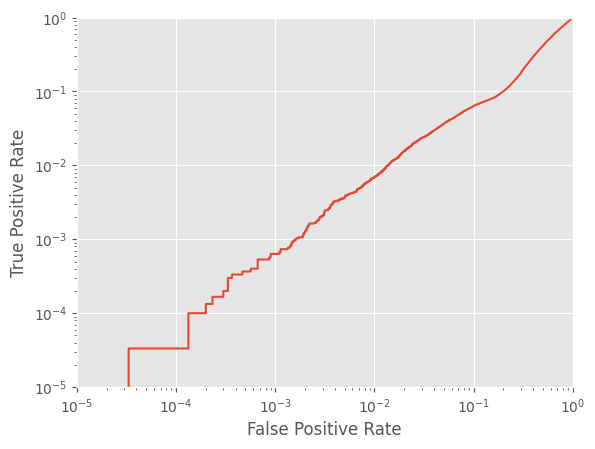

In [50]:
fpr, tpr, _ = metrics.roc_curve(member_indicators,  member_scores)
auc = metrics.roc_auc_score(member_indicators,  member_scores)
plt.loglog(fpr, tpr)
plt.xlim(10**-5,  1)
plt.ylim(10**-5,  1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

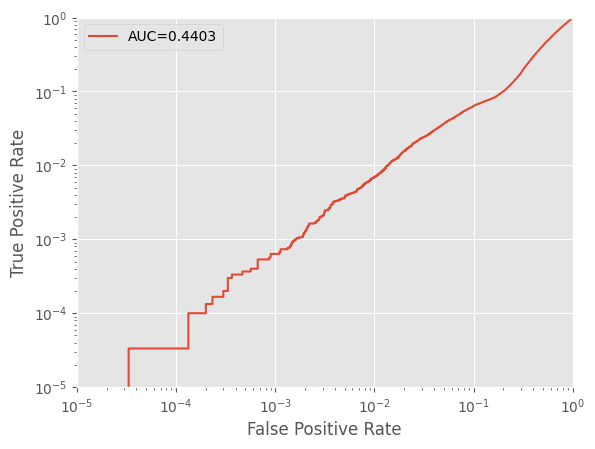

In [51]:
fpr, tpr, _ = metrics.roc_curve(member_indicators, member_scores)
auc = metrics.roc_auc_score(member_indicators, member_scores)

plt.loglog(fpr, tpr, label=f'AUC={auc:.4f}')
plt.xlim(10**-5, 1)
plt.ylim(10**-5, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()